# Paper title: Geometric properties of PalmTree instruction embeddings
## Target IJCNN, deadline: End of January


## **Overview**
*   Geometry of embeddings
*   Pairwise correlations
*   Find which are closer to which 
*   Analog relationship or outlier detection, see how embeddings relate different instructions
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search \

**Pairwise correlations** 
*   Correlations of the embeddings, plot them on histogram 
*   Relies on inner products between two vectors,

**Analyze** 
*   call, ret, mov, etc. most important instructions in malware analysis
*   Pick common instructions, look at embeddings see which ones are closer
*   Prediction "non of embeddings will be close/ will be perpendicular" 
*   Look at the vectors, for constants 0, 1, 2, etc. 

**Analog query** 
*   K nearest neighbors  
*   Look at vectors in  each layer, as input goes through, can see performance for analog query 
*   Find vector for king, minus vector for man + woman. find vector closest to this, see if result vector is close to king 
*   Outlier detection, look at each layer 

**Plot of embedding norms** 
*   Norm inverserly related to the frequency of tokens 
*   The most frequent tokens had smallest norm in Bert 

**For outliers, see accuracy of outliers from layer to layer**
*   Given sequence, see how it changes through the layers 
*   Look at number of layers in model 

**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   Figure out how to improve it, possible encod epair of instructions at a time

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   See if it improves 







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained


In [3]:
!pip install bert-pytorch

## Import and Load PalmTree model

In [4]:
import os
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils

import vocab
import pickle

palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

# tokens has to be seperated by spaces.

text = ["mov rbp rdi", 
        "mov ebx 0x1", 
        "mov rdx rbx", 
        "call memcpy", 
        "mov [ rcx + rbx ] 0x0", 
        "mov rcx rax", 
        "mov r13 qword [ rax ]",
        "mov [ rax ] 0x2e"]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
#for i in range(7):
#  print("usable embedding of this basicblock:", np.corrcoef(embeddings))
print("usable embedding of this basicblock:", np.linalg.norm(embeddings))

print("the shape of output tensor: ", embeddings.shape)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
usable embedding of this basicblock: 74.63446
the shape of output tensor:  (8, 128)


## Test Vocabulary

In [5]:
#Test Vocabulary
vocab_path = "./palmtree/vocab"
with open(vocab_path, "rb") as file:
  data = file.read()
  tokens = pickle.loads(data)
num_of_tokens = len(tokens)
print(tokens.to_seq(sentence="retn rbp 0x1"))
print(tokens.from_seq(seq=[5, 14, 19], join=True))
print('number of tokens', num_of_tokens)
print(tokens.from_seq(seq=list(range(0,num_of_tokens)), join=False))

[68, 14, 28]
mov rbp rdi
number of tokens 6631
['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'mov', '[', ']', 'rax', '+', 'qword', 'address', 'eax', 'rsp', 'rbp', 'rbx', 'symbol', 'rdx', 'call', 'rdi', '-', 'dword', 'add', 'rsi', 'rcx', 'cmp', 'je', '0x8', '0x1', 'test', 'edx', 'byte', 'r12', 'lea', 'jne', 'pop', '0x0', 'jmp', 'r13', 'r14', 'xor', 'r15', 'esi', 'ecx', 'edi', '0x10', '0x28', '0x18', 'al', 'movzx', '0x20', 'sub', 'rel', 'r8', 'and', 'ebx', 'push', '0x30', 'string', '*', '0x38', '0x4', 'ebp', 'r9', 'or', '0x48', '0x40', '0x2', 'retn', 'r8d', ':', 'shl', 'fs', 'r12d', 'r10', 'r9d', '8', 'r13d', '0x5', '0x3', 'cl', 'r14d', 'ja', 'dl', '0x58', '0x50', 'r15d', 'shr', '0x60', '0x68', 'r11', 'jbe', 'word', 'jae', '0x80', '0x70', '0xc', 'movsxd', 'xmm0', 'jb', '0x90', 'xmmword', '0x78', '0xffffffffffffffff', '0x100', 'nop', '0x88', 'r10d', '4', '0xf8', '0x98', 'imul', '0x14', '0x6', 'setne', 'sete', '0xb0', 'bl', 'r11d', '0xa', '2', 'ax', 'cmovne', 'cmove', '0xa8', '0x7', '0xa0

## Correlation Coefficients of the Embeddings' Weights

In [6]:
embedding_weights = palmtree.model.embedding
print(embedding_weights)

BERTEmbedding(
  (token): TokenEmbedding(6631, 128, padding_idx=0)
  (position): PositionalEmbedding()
  (segment): SegmentEmbedding(3, 128, padding_idx=0)
  (dropout): Dropout(p=0.1, inplace=False)
)


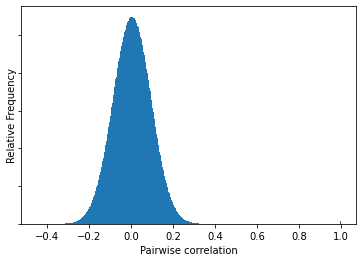

In [14]:
#Pair-wise Correlation
import pandas as pd
import matplotlib.pyplot as plt
embedding_weights = pd.DataFrame(palmtree.model.embedding.token.weight.cpu().detach().numpy())
#print(embedding_weights)
#for i in range(10):
#  print(np.linalg.norm(embedding_weights[i]))
#print(np.corrcoef(embedding_weights[0], embedding_weights[1]))
#print(embedding_weights.transpose().corr())

df = pd.DataFrame(embedding_weights.transpose().corr().to_numpy().flatten())
#print(df)
df.columns = [""]
fig, ax = plt.subplots()
plt.xlabel("Pairwise correlation")
plt.ylabel("Relative Frequency")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    labelleft=False)
df.hist(bins=512, grid=False, figsize=(12,8), ax=ax)
fig.savefig('histogram_final.pdf')

## Rank closest Tokens in terms of Cosine Similarity 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
cs = cosine_similarity(embedding_weights)

In [ ]:
df2 = pd.DataFrame(cs)
print(df2)

          0         1         2     ...      6628      6629      6630
0     1.000000 -0.161538  0.001978  ...  0.019877  0.114243 -0.009327
1    -0.161538  1.000000 -0.035013  ... -0.156192 -0.070517  0.054605
2     0.001978 -0.035013  1.000000  ... -0.081467 -0.068712  0.151721
3     0.192207 -0.108298  0.208390  ... -0.004799  0.104951 -0.014524
4     0.167583 -0.177007  0.088277  ...  0.183628  0.141970  0.122955
...        ...       ...       ...  ...       ...       ...       ...
6626 -0.157638 -0.099611  0.075437  ...  0.135751  0.133686 -0.063076
6627  0.091964 -0.123479 -0.008748  ...  0.032066  0.059562  0.038342
6628  0.019877 -0.156192 -0.081467  ...  1.000000  0.050292 -0.070612
6629  0.114243 -0.070517 -0.068712  ...  0.050292  1.000000 -0.001307
6630 -0.009327  0.054605  0.151721  ... -0.070612 -0.001307  1.000000

[6631 rows x 6631 columns]


In [ ]:
embedding_weights.shape
print(tokens.to_seq(sentence="add sub xor"))
print(tokens.from_seq(seq=[22, 51, 40], join=False))

[22, 51, 40]
['add', 'sub', 'xor']


In [ ]:
import collections
add_cs_pairs = dict()
for i in range(cs[22].shape[0]):
  add_cs_pairs[i] = cs[22][i] 
print(add_cs_pairs) #add

add_cs_sorted = sorted(add_cs_pairs.items(), key=lambda x: x[1], reverse=True)
print(add_cs_sorted)
type(add_cs_sorted)
#with np.printoptions(threshold=np.inf):
#print(cs[22])

{0: 0.023293266, 1: -0.07580692, 2: -0.025744312, 3: 0.087671325, 4: 0.06427405, 5: 0.10079847, 6: 0.020061446, 7: 0.07788986, 8: -0.024368595, 9: 0.075190395, 10: 0.04000448, 11: 0.09109944, 12: 0.051405333, 13: -0.010715011, 14: -0.037802376, 15: -0.08026075, 16: -0.0066160066, 17: 0.16739918, 18: 0.08141359, 19: 0.048880655, 20: 0.079651766, 21: 0.051755436, 22: 1.0, 23: 0.039396927, 24: 0.09406462, 25: -0.050150763, 26: 0.04493473, 27: 0.041041818, 28: -0.05247958, 29: -0.07946928, 30: 0.040989693, 31: 0.19420205, 32: 0.013751128, 33: 0.032080937, 34: 0.013268068, 35: -0.0009186314, 36: -0.058395065, 37: 0.09545154, 38: -0.016295468, 39: 0.04306165, 40: -0.025167761, 41: 0.18276337, 42: 0.0142879225, 43: 0.06520452, 44: -0.11826515, 45: -0.11970786, 46: 0.1301663, 47: 0.018214943, 48: -0.06402897, 49: -0.00401113, 50: 0.009464728, 51: 0.17511752, 52: 0.023291543, 53: 0.16914575, 54: 0.028531764, 55: 0.0980784, 56: 0.062887706, 57: 0.1442268, 58: 0.033240434, 59: 0.11701534, 60: -0.

list

In [ ]:
#get first N numer of elements from add_cs_sorted
num = 20
ranks = np.zeros(num, dtype =int)
cs_values = np.zeros(num)
for i in range(num):
  (rank, cs_value) = add_cs_sorted[i]
  ranks[i] = rank
  cs_values[i] = cs_value

['add', '0x72b4668d', '0xffffff3c', '0x18806000000', '0x254c226d', '0x62baa847', '0x9bd', '0x254b2485', '0x2560807d', 'seto', '0x68a39c5a', '0x25612511', '0x84c87814', '0x25412f38', '0x614aa021', '0x68db8bad', '0x25612489', '0x8cc70208', '0x6160a005', '0xd21']


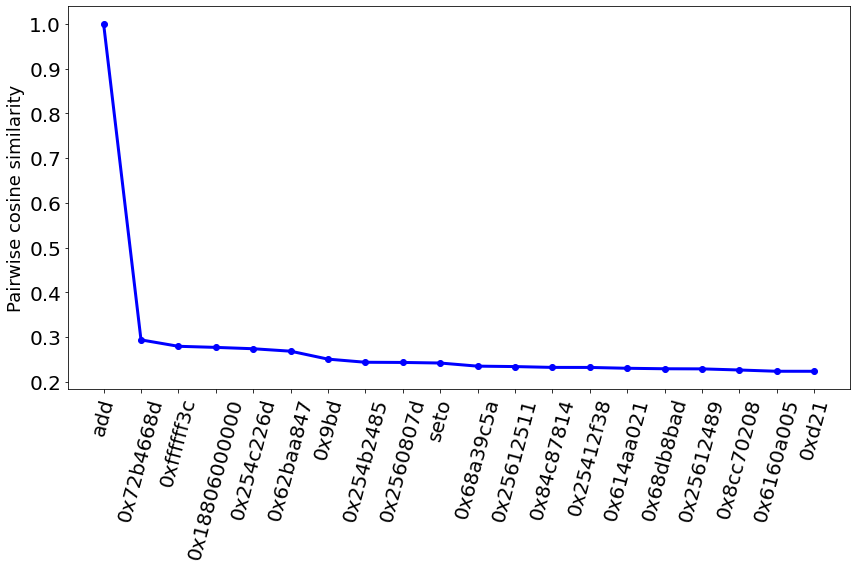

In [ ]:
#Take one token:add, then find the 20 tokens with the highest similarity to this token
from numpy.__config__ import show
from matplotlib.font_manager import FontProperties
fig, (ax1) = plt.subplots(1, figsize=(12,8))


ax1.plot(cs_values, '-ok', linewidth=3, color='b')
#ax1.set_title("add", fontsize=28)    # Don't need a title 
#sort cs[22] according to simlarity values


x_vals = tokens.from_seq(seq=ranks, join=False)
print(x_vals)
  
for ax in fig.get_axes():
    ax.set_xticks(np.arange(0,len(x_vals)))
    ax.set_xticklabels(x_vals, rotation=75, fontsize=20)
    plt.yticks(fontsize = 20)
    ax.set_ylabel('Pairwise cosine similarity', fontsize= 18)
    ax.label_outer() 
plt.tight_layout()
plt.savefig("add_cosine_sim_sorted_final.pdf")

### Same analysis for an operand token

In [ ]:
print(tokens.to_seq(sentence="add sub 0x1"))
print(tokens.from_seq(seq=[22, 51, 28], join=False))

[22, 51, 28]
['add', 'sub', '0x1']


In [ ]:
import collections
add_cs_pairs = dict()
for i in range(cs[28].shape[0]):
  add_cs_pairs[i] = cs[28][i] 
print(add_cs_pairs) #add

add_cs_sorted = sorted(add_cs_pairs.items(), key=lambda x: x[1], reverse=True)
print(add_cs_sorted)
type(add_cs_sorted)

{0: -0.05209284, 1: -0.13242556, 2: 0.006422391, 3: 0.0065753837, 4: -0.0012880163, 5: -0.013618696, 6: 0.025067866, 7: -0.075578414, 8: 0.05594003, 9: 0.03868265, 10: 0.10749284, 11: -0.043791305, 12: 0.010523602, 13: 0.06602736, 14: -0.07401987, 15: 0.040458202, 16: 0.12430365, 17: 0.09131099, 18: -0.023046782, 19: -0.2507619, 20: -0.034763604, 21: 0.05541379, 22: -0.05247958, 23: -0.081334926, 24: 0.12091355, 25: 0.063437544, 26: 0.0551554, 27: 0.16052581, 28: 1.0, 29: 0.09217941, 30: 0.06453904, 31: 0.12130359, 32: 0.046824493, 33: -0.028772159, 34: 0.066375315, 35: -0.04966622, 36: 0.20309633, 37: 0.0052156355, 38: -0.035958026, 39: -0.063525006, 40: -0.015639994, 41: 0.0026677873, 42: 0.0065009366, 43: -0.09402255, 44: 0.03956473, 45: 0.0939236, 46: 0.23206435, 47: -0.11309251, 48: 0.08721416, 49: 0.18425116, 50: -0.017301276, 51: -0.14259335, 52: 0.016173966, 53: 0.07046118, 54: -0.04319883, 55: -0.0023995223, 56: 0.0025206837, 57: -0.055841535, 58: 0.13609695, 59: -0.019415982,

list

In [ ]:
#get first N numer of elements from add_cs_sorted
num = 20
ranks = np.zeros(num, dtype =int)
cs_values = np.zeros(num)
for i in range(num):
  (rank, cs_value) = add_cs_sorted[i]
  ranks[i] = rank
  cs_values[i] = cs_value

['0x1', '0xa3', '0x4e87b58e', 'cmovl', '0x7ffffffe', '0x6e656720', '0xd12', '0x614b75e9', '0x254a9095', '0x6ffffffa', '0x2bd', '0x1a', '0xffffff81', '0x2cd', '0x70000000', '0x7661ef38', '0x254a958d', '0x6fa88c61', '0x679', '0x254a81e1']


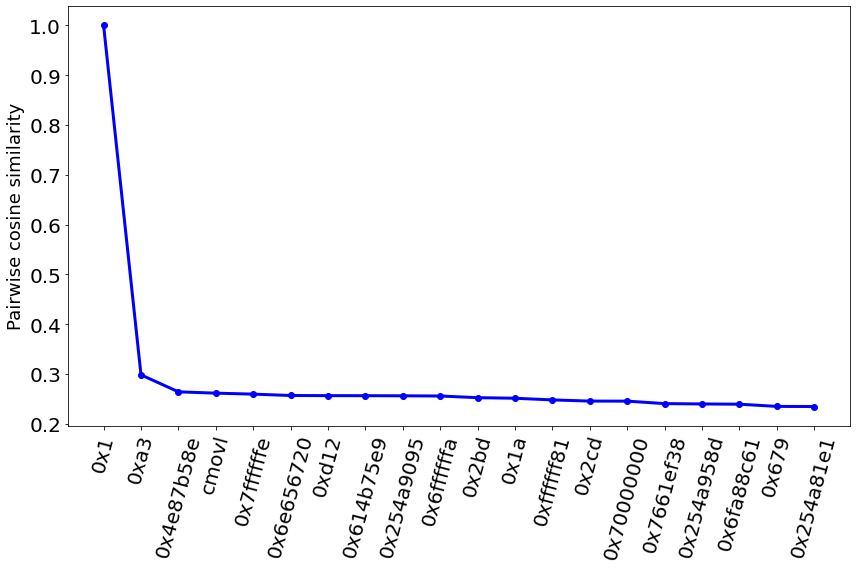

In [ ]:
#Take one token:0x1, then find the 20 tokens with the highest similarity to this token
from numpy.__config__ import show
from matplotlib.font_manager import FontProperties
fig, (ax1) = plt.subplots(1, figsize=(12,8))


ax1.plot(cs_values, '-ok', linewidth=3, color='b')
#sort cs[22] according to simlarity values


x_vals = tokens.from_seq(seq=ranks, join=False)
print(x_vals)
  
for ax in fig.get_axes():
    ax.set_xticks(np.arange(0,len(x_vals)))
    ax.set_xticklabels(x_vals, rotation=75, fontsize=20)
    plt.yticks(fontsize = 20)
    ax.set_ylabel('Pairwise cosine similarity', fontsize= 18)
    ax.label_outer() 
plt.tight_layout() 
plt.savefig("hex1_cosine_sim_sorted_final.pdf")

## Rank Closest Instructions based on Cosine Similarity of their Embeddings

In [ ]:
#Get all the instructions Embeddings, and then Rank them
#Read the opcode.pkl file and initialize offsets for Instruction groups
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
opcode_group_file = "./intrinsic_eval/opcode.pkl"

with open(opcode_group_file, 'rb') as f:
    instruction_set = pickle.load(f)

instruction_groups = dict()

#print('instruction_set is a',type(instruction_set))
offset = 0
for ins in instruction_set:
  ins_list = instruction_set[ins]
  instruction_groups[ins] = []
  instruction_groups[ins].append(offset) #start_index
  instruction_groups[ins].append(len(ins_list)+offset-1) #end_index
  offset += len(ins_list)
#num_of_ins += len(instruction_set[ins])
#print('number of instructions:' , num_of_ins)


#instruction_groups keeps a mapping of an instruction category(i.e. MOV) and start & end indices in that category
for key, val in instruction_groups.items():
    print(key, val)

MOV [0, 4205]
BINOP [4206, 5948]
CALL [5949, 5973]
CMP [5974, 7245]
JMP [7246, 7285]
SHIFT [7286, 7438]
CSET [7439, 7482]
CMOV [7483, 7674]
UNARY [7675, 7699]
FP [7700, 7702]


In [ ]:
for key in instruction_set:
  print(key, instruction_set[key])

MOV {'mov,edi,0x50', 'mov,rsi,0x5858585858587543', 'mov,rax,qword [ r8 + 0x8 ]', 'mov,dword [ ecx + ebx * 8 - 0x8 ],eax', 'mov,r15,rax', 'mov,byte [ rsp + 0x55 ],0x1', 'mov,edx,dword [ ebp - 0x34 ]', 'mov,r8d,0x30', 'mov,dword [ rsp + 0x40 ],0x180', 'mov,dword [ ebp - 0x120 ],eax', 'mov,qword [ rsp + 0x70 ],0x0', 'mov,eax,dword [ esp + 0xc ]', 'mov,ecx,dword [ rsp + 0xc8 ]', 'mov,byte [ rsp + 0x53 ],0x1', 'mov,byte [ rbp - 0x338 ],r8b', 'mov,rax,qword [ rdx + 0x60 ]', 'mov,byte [ eax + 0x3 ],cl', 'mov,qword [ rbp - 0x340 ],rcx', 'mov,dword [ ebp - 0x4 ],address', 'mov,rdi,qword [ rbp - 0x318 ]', 'mov,r12d,0x61', 'mov,rdx,qword [ rbp + 0x40 ]', 'mov,r9,qword [ rbp - 0x318 ]', 'mov,dword [ esp + 0x30 ],eax', 'mov,rdi,qword [ rdi ]', 'mov,r12,rbx', 'mov,r10,r13', 'mov,r11d,address', 'mov,byte [ r11 ],0x6c', 'mov,dword [ rbp - 0x308 ],eax', 'mov,qword [ rax + 0x8 ],rdi', 'mov,rsi,qword [ rbp - 0x2f0 ]', 'mov,rax,qword [ r12 + 0x28 ]', 'mov,r11,qword [ rsp + 0x18 ]', 'mov,edx,dword [ esp + 

### Utility Methods

In [ ]:
#method which can get the instruction from instruction_set
#using the instruction_group key and index'
#Do We Really Need this?
def fetch_instruction(_index):

  for key, val in instruction_groups.items():
    start_index = instruction_groups[key][0]
    end_index = instruction_groups[key][1]
    if(_index>=start_index and _index<=end_index):
      idx = _index-start_index
      size = len(instruction_set[key])
      #print('Group:', key,"Index:", idx,"Size:",size)
      if(idx>=size):
        print("Error!")
        return ""
      return list(instruction_set[key])[idx]


#Testing fetch_instruction(_index) method
ins = fetch_instruction(20)
print(ins)

mov,r12d,0x61


In [ ]:
#Get the Embeddings for an insruction from the outlier_check_list
#Use Index from outlier_check_list
def GetInstructionEmbedding(embd_matrix, ins_index):
  size = embd_matrix.shape[0]
  if(size <= ins_index):
    print("Wrong Index!")
    return
  else:
    return embd_matrix[ins_index]


In [ ]:
#get index of an instruction
#for 'or,ecx,r10d'
idx = 0;
for inst in instruction_set['BINOP']:
  if(inst=='or,ecx,r10d'):
    print(inst,'found at', idx)
  idx +=1

or,ecx,r10d found at 1391


### Load the Embeddings from pickle file and Analyze

In [ ]:
#Unpickle the embeddings, and check it out 
with open('opcode_instructions_embeddings.pkl', 'rb') as f:
    embeddings_list = pickle.load(f)

In [ ]:
#check the shape of the embeddings 
all_embeddings = np.array(embeddings_list)
print(all_embeddings.shape)
#print('Sample Embedding:')
for i in range(0, 0):
  print(all_embeddings[i])

(7703, 128)


In [ ]:
cs_ins = cosine_similarity(all_embeddings)
df_ins = pd.DataFrame(cs_ins)
print(df_ins)

          0         1         2     ...      7700      7701      7702
0     1.000000  0.390479  0.090616  ... -0.044883 -0.019186  0.025836
1     0.390479  1.000000  0.214152  ...  0.143757  0.236602  0.171809
2     0.090616  0.214152  1.000000  ...  0.184287  0.228035  0.220932
3     0.409015  0.826190  0.166239  ...  0.135154  0.208863  0.146271
4     0.316499  0.364483  0.160870  ...  0.465181  0.485941  0.471025
...        ...       ...       ...  ...       ...       ...       ...
7698 -0.059518  0.121860  0.112272  ...  0.692646  0.586984  0.498028
7699 -0.004902  0.221478  0.208943  ...  0.663659  0.687612  0.564255
7700 -0.044883  0.143757  0.184287  ...  1.000000  0.859266  0.688543
7701 -0.019186  0.236602  0.228035  ...  0.859266  1.000000  0.676731
7702  0.025836  0.171809  0.220932  ...  0.688543  0.676731  1.000000

[7703 rows x 7703 columns]


In [ ]:
idx= 5597
print(fetch_instruction(idx))

or,ecx,r10d


In [ ]:
import collections
mov_ins_pairs = dict()
for i in range(cs_ins[4210].shape[0]):
  mov_ins_pairs[i] = cs_ins[idx][i] 
print(mov_ins_pairs) #add 
mov_ins_sorted = sorted(mov_ins_pairs.items(), key=lambda x: x[1], reverse=True)
print(mov_ins_sorted)
type(mov_ins_sorted)

{0: 0.09713682, 1: 0.007893094, 2: 0.1059738, 3: -0.09223236, 4: 0.14318994, 5: 0.0732452, 6: 0.22842166, 7: 0.17642553, 8: 0.047602315, 9: -0.01837744, 10: 0.061760195, 11: 0.038119733, 12: 0.009893655, 13: 0.2723576, 14: 0.10356929, 15: 0.16513187, 16: 0.20421056, 17: 0.19444275, 18: 0.11820652, 19: 0.098366305, 20: 0.124699965, 21: 0.19410908, 22: 0.050042808, 23: 0.16036244, 24: 0.2155424, 25: -0.031962473, 26: 0.13838756, 27: 0.21066809, 28: 0.1373546, 29: -0.037069727, 30: 0.1366341, 31: 0.20091091, 32: 0.18480799, 33: 0.2408812, 34: 0.11477956, 35: 0.25107378, 36: 0.17454419, 37: 0.23567586, 38: 0.043951362, 39: 0.124684416, 40: 0.0038904604, 41: 0.18592997, 42: 0.08023949, 43: 0.16736609, 44: 0.021186767, 45: 0.24453846, 46: 0.28279734, 47: 0.14697425, 48: 0.0849752, 49: 0.19342998, 50: 0.045583982, 51: 0.12372403, 52: 0.14561519, 53: 0.28161308, 54: 0.01005805, 55: 0.02544286, 56: 0.051274747, 57: 0.15996246, 58: 0.017927432, 59: 0.030655801, 60: -0.015171177, 61: 0.020855911,

list

In [ ]:
#get first N numer of elements from mov_ins_sorted
num = 20
ranks = np.zeros(num, dtype =int)
cs_values = np.zeros(num)
for i in range(num):
  (rank, cs_value) = mov_ins_sorted[i]
  ranks[i] = rank
  cs_values[i] = cs_value

['or,ecx,r10d', 'lea,esi,[ ebx + edx ]', 'or,esi,dword [ rbp - 0x3a4 ]', 'mov,dword [ rsp ],ebp', 'sub,r8d,dword [ rsp + 0x30 ]', 'sub,r13,rbx', 'sub,esp,0x10c', 'sub,rax,rcx', 'add,r12,r14', 'lea,eax,[ rsi - 0x30 ]', 'or,esi,dword [ rbp - 0x35c ]', 'add,rdi,qword [ rbp - 0x328 ]', 'lea,eax,[ ebp - 0x14 ]', 'or,eax,dword [ ebp - 0x1c ]', 'lea,rbx,[ rsi + 0x1 ]', 'xor,ebx,0x1', 'and,esi,0x4', 'add,qword [ r13 + 0x18 ],0x1', 'lea,rsi,[ rsp + 0x40 ]', 'add,eax,ebx']


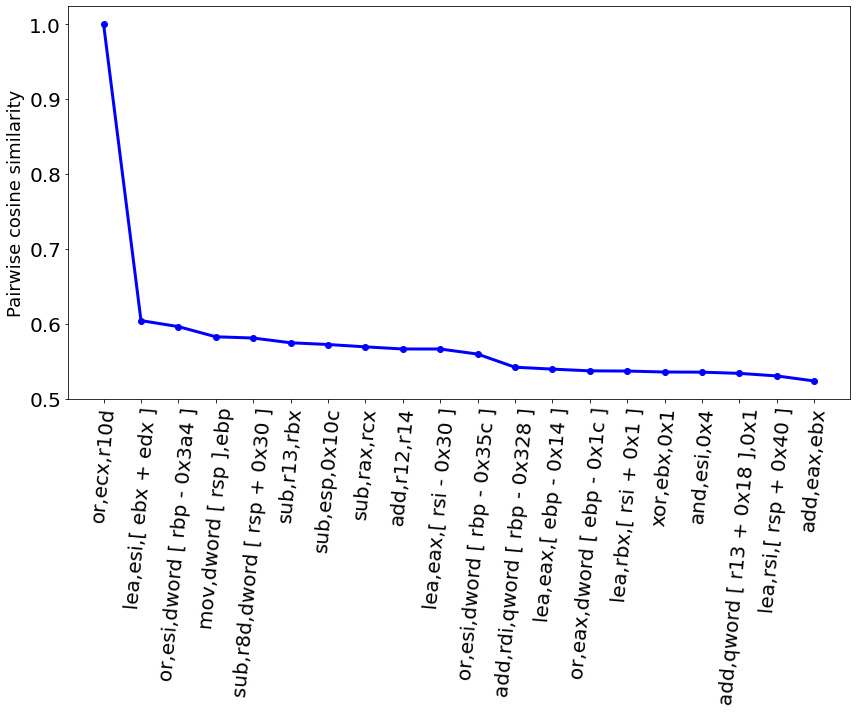

In [ ]:
#Take one instruction:MOV, then find the 20 Instructions with the highest similarity to this token
from numpy.__config__ import show
from matplotlib.font_manager import FontProperties
#fig, (ax1) = plt.subplots(1, figsize=(20,30))
fig, (ax1) = plt.subplots(1, figsize=(12, 10))


ax1.plot(cs_values, '-ok', linewidth=3, color='b')
#ax1.plot(cs_values), ax1.set_title(fetch_instruction(idx), fontsize=20)  

x_vals = []
for i in range(len(ranks)):
  x_vals.append(fetch_instruction(ranks[i]))
print(x_vals)
  
for ax in fig.get_axes():
    ax.set_xticks(np.arange(0,len(x_vals)))
    ax.set_xticklabels(x_vals, rotation = 85, fontsize=20)
    plt.yticks(fontsize = 20)
    ax.set_ylabel('Pairwise cosine similarity', fontsize= 18)
    ax.label_outer()
plt.tight_layout()
plt.savefig("ins_cosine_sim_sorted_final.pdf")

## Look at Magnitudes of Token Embeddigns

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
len = embedding_weights.shape[0]
norms = np.zeros(len)
for i in range(0,len):
  magnitude = np.linalg.norm(embedding_weights[i])
  norms[i] = magnitude


#with np.printoptions(threshold=np.inf):
norms = norms.reshape(len,1)
print(norms)

print(embedding_weights.shape)
print(norms.shape)

[[ 1.61134303]
 [10.18611622]
 [ 7.69792366]
 ...
 [ 9.59264755]
 [ 9.73288822]
 [ 9.57337475]]
(6631, 128)
(6631, 1)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4424cbfc10>],
      dtype=object)

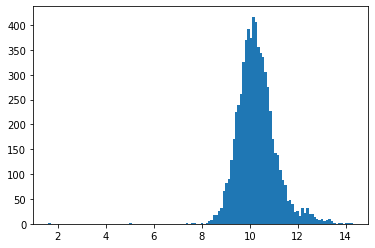

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.hist(norms,figsize=(100,200))
#fig = plt.figure(figsize=(100,200))
#plt.show()
df4 = pd.DataFrame(norms)
df4.columns = [""]
fig, ax = plt.subplots()
df4.hist(bins=124, grid=False, figsize=(14,18), ax=ax)

## The END

In [ ]:
dot_matrix=np.dot(embedding_weights,embedding_weights.T)
print(dot_matrix.shape)

(6631, 6631)


In [ ]:
df3 = pd.DataFrame(dot_matrix)
print(df3)

          0           1          2     ...       6628       6629       6630
0     2.596426   -2.651378   0.024531  ...   0.307237   1.791669  -0.143878
1    -2.651378  103.757004  -2.745406  ... -15.261813  -6.991083   5.324801
2     0.024531   -2.745406  59.258030  ...  -6.015835  -5.148122  11.181058
3     2.287305   -8.147012  11.847245  ...  -0.339960   7.543874  -1.026896
4     1.363271   -9.102576   3.430715  ...   8.892861   6.975940   5.942616
...        ...         ...        ...  ...        ...        ...        ...
6626 -2.484464   -9.924257   5.679893  ...  12.736900  12.726507  -5.906262
6627  1.488309  -12.632543  -0.676360  ...   3.089364   5.822310   3.686621
6628  0.307237  -15.261813  -6.015835  ...  92.018883   4.695457  -6.484618
6629  1.791669   -6.991083  -5.148122  ...   4.695457  94.729149  -0.121824
6630 -0.143878    5.324801  11.181058  ...  -6.484618  -0.121824  91.649521

[6631 rows x 6631 columns]


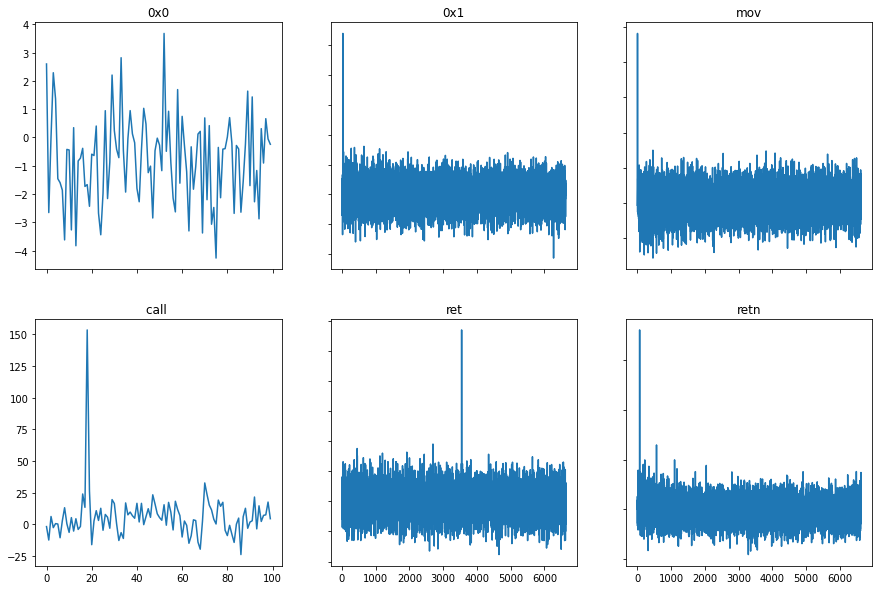

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(df3[0][0:100]), ax1.set_title("0x0")       # 0x0
ax2.plot(df3[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(df3[5]), ax3.set_title("mov")       # mov
ax4.plot(df3[18][0:100]), ax4.set_title("call ")    # call 
ax5.plot(df3[3546]), ax5.set_title("ret")    # ret
ax6.plot(df3[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()  